## Hedging strategies:

- Delta hedging:

    $$\Delta = \frac{\partial C^{BS}}{\partial S} = \mathcal{N}(d_1)$$

    where,
    
    $\Delta =$ delta, $C=$ Call Option, $BS=$  Black-Scholes, $S =$ Underlying and $d_1 =$ first term from the Black-Scholes.

    Underlying asset = NVDA.O

    Maturity Date = 2024-10-25
    
    T = 45
    
    Start date = 2024-09-10

In [10]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.stats import norm

date = dt.datetime.strptime('2024-10-25', '%Y-%m-%d')
t = 45 - (date - dt.datetime.strptime('2024-09-11', '%Y-%m-%d')).days
date1 = date - dt.timedelta(days=45)
print(date1, t)

data = pd.read_feather('apple.feather')
# drop unnecessary three rows as our hedging starting day is 2024-09-10
df = data.drop(index=[0,1,2]).reset_index(drop=True)

2024-09-10 00:00:00 1


In [2]:
def calculate_delta(S, K, T, t, r, sigma, eps):
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    return norm.cdf(d1)

$$d_1 = \frac{\ln (S/T)+(r+\sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$$
$$d_2 = d_1 - \sigma \cdot \sqrt{T-t}$$

In [3]:
# Black-Scholes Call Price
def black_scholes_call(S, K, T, t, r, sigma, eps):
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [4]:
def interval_func(start, end, interval):
    result = []
    current = start
    while current <= end:
        result.append(round(current, 4))
        current += interval
    return result

#interval_func(0.5, 0.001, 1000)

In [6]:
# ATM 2024-09-10
T = 45/365
C_0 = 10
S_0 = 108.1
t = 0
K = 105
# Risk-free rate is us 30-day treasure bond risk-free rate at 2024-09-10
r = 0.0497
eps = np.finfo(float).eps
# sigma = ?

In [7]:
print(black_scholes_call(S=124.92, K=K, T=T, t=t, r=r, sigma=0, eps=eps))

20.561409619746456


In [8]:
"""
S = Underlying price at the date
K = Strike Price
T = Time to maturity (years)
t = day now
interval = re-hedging interval (days)
C_= Call price

Func finds volatility to the call option and calculates delta
"""

def calc_delta(S, K, T, t, r, C_0, eps=np.finfo(float).eps, tol=0.2):

    for sigma in interval_func(0, 4, 0.001):
        c = black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
        if abs(c-C_0) <= tol:
            delta = calculate_delta(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
            print(f"Delta = {delta}, sigma = {sigma} call price from BS = {round(c, 5)}")
            return delta
    print(c)
    return None

#calc_delta(S_0, K, T, t, r, C_0)

In [9]:
black_scholes_call(S=S_0, K=K, T=T, t=t, r=r, sigma=0.53789, eps=eps)

10.000999061418113

In [19]:
# ATM 2024-09-10
T = 45/365
C_0 = 10
S_0 = 108.1
t = 0
K = 105

# Risk-free rate is us 30-day treasure bond risk-free rate at 2024-09-10
r = 0.0497
eps = np.finfo(float).eps
sigma = 0.53789

In [20]:
delta = calculate_delta(S=S_0, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
print(f"Delta = {delta}")

Delta = 0.610619678591889


In [28]:
delta * S_0

np.float64(66.0079872557832)

We have n=45 days to the maturity $t_0=0$. We have one call option with price $C_0 = 10$ on that date 2024-09-10. Then we have another portfolio containing delta amount of underlying asset which is $\Delta_0 \cdot S_0 = 0.6073354 \cdot 108.1 = 65.6530$

In [22]:
"""
 Now we compute how much the value of the OP and RE changes on each day.
 OP value change is calculated as C_1 - C_0 where C_0 is value before C_1. Data is stored to the OP_value array in increasing date order
 as the original data in the firma1.feather


"""

c_0 = 0.0
OP_value = []

for i, row in df.iterrows():
    if i == 3:
        c_0 = float(row['C105'])
        continue

    c_1 = float(row['C105'])
    c_out = c_1 - c_0

    OP_value.append(round(c_out, 4))
    c_0 = float(row['C105'])

In [23]:
"""
 RE value change is calculated as s_1 - s_0 where s_0 is underlying value before s_1. Data is stored to the RE_value array in increasing date order
 as the original data in the firma1.feather
"""

s_0 = 0
RE_value = []


for i, row in df.iterrows():
    if i == 3:
        s_0 = float(row['Underlying'])
        continue

    s_1 = float(row['Underlying'])

    s_out = s_1 - s_0
    RE_value.append(round(s_out, 4))
    s_0 = float(row['Underlying'])

In [24]:
# ATM 2024-09-10
T = 45/365
C_0 = 10
S_0 = 108.1
t = 0
K = 105

# Risk-free rate is us 30-day treasure bond risk-free rate at 2024-09-10
r = 0.0497
eps = np.finfo(float).eps

In [25]:
"""
We want to re-hedge the portfolio at specific intervals and calculate mean square error E = (1 / n - 1) * SUM_i=1->n-1(A^2)
We choose to hedge every second day.
Function calculates both OP and RE portfolio values and their difference A_i as the result.
Re-hedging is done by calculating new delta values.

OP = c_i+1 - c_1
RE = delta_i(s_i+1 - s_i)
A_i = OP + RE
E = (1 / n - 1) * SUM_i=1->n-1(A_i^2)

interval = re-hedging interval (days)
strike = strike price in format ('C{strike_price}) e.g. 'C105'
"""

OP_0 = C_0

# delta * S_0
RE_0 = 0.6073354 * S_0

maturity_date = dt.datetime.strptime('2024-10-25', '%Y-%m-%d')

def hedging(interval, strike, df):
    A_boss = 0
    interval_count = 1
    c_0 = C_0
    c_1 = 0
    s_0 = S_0
    s_1 = 0
    delta = 0.6073354
    t = 0
    n = 0

    for _, row in df.iterrows():
        c_1 = float(row[strike])
        s_1 = float(row['Underlying'])
        t = (45 - (maturity_date - row['Date']).days) / 365
        
        if row.name == 1:
            continue

        OP = c_1 - c_0

        
        RE = delta * (s_1-s_0)
        A = OP + RE
        A_boss += A ** 2
        n += 1
        
        if interval_count % interval == 0:
          print(row['Date'].strftime("%Y-%m-%d"))
          delta = calc_delta(s_1, K, T, t, r, c_1)
          

        c_0 = c_1
        s_0 = s_1
        interval_count += 1

    mse = A_boss/(1-n)
    
    return mse



In [26]:
hedging(interval=2, strike='C105', df=df)

2024-09-12


Delta = 0.781294871618629, sigma = 0.567 call price from BS = 18.13369
2024-09-16
Delta = 0.7796114652750301, sigma = 0.495 call price from BS = 15.40689
2024-09-18
Delta = 0.7436559904139446, sigma = 0.439 call price from BS = 12.12932
2024-09-20
Delta = 0.8257215404056265, sigma = 0.384 call price from BS = 13.4567
2024-09-24
Delta = 0.9096599957820639, sigma = 0.388 call price from BS = 17.55138
2024-09-26
Delta = 0.9575444103917264, sigma = 0.362 call price from BS = 20.18315
2024-09-30
Delta = 0.9835944639469222, sigma = 0.271 call price from BS = 17.25074
2024-10-02
Delta = 0.9171607973508984, sigma = 0.378 call price from BS = 15.60487
2024-10-04
Delta = 1.0, sigma = 0 call price from BS = 20.56141
2024-10-08
75.69407241120491


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

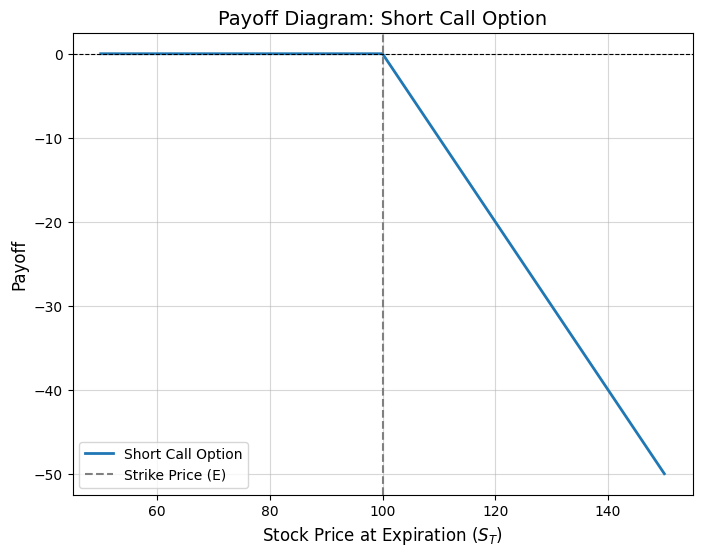

In [1]:
# Reimporting libraries and plotting again due to execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Define parameters for the short call option
strike_price = 100  # Strike price (E)
stock_prices = np.linspace(50, 150, 500)  # Range of stock prices at expiration (S_T)

# Calculate the payoff for the short call option
payoff = np.minimum(0, -(stock_prices - strike_price))

# Plot the payoff diagram
plt.figure(figsize=(8, 6))
plt.plot(stock_prices, payoff, label="Short Call Option", linewidth=2)

# Add strike price as a reference
plt.axvline(x=strike_price, color="gray", linestyle="--", label="Strike Price (E)")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Zero payoff line

# Customize the plot
plt.title("Payoff Diagram: Short Call Option", fontsize=14)
plt.xlabel("Stock Price at Expiration ($S_T$)", fontsize=12)
plt.ylabel("Payoff", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.show()


Iton lemma on stokastisen laskennan perustyökalu, jota käytetään stokastisten prosessien, jotka sisältävät Brownin liikkeen, derivaattojen laskemiseen. Se on tavallisen ketjusäännön laajennus stokastiseen ympäristöön.
Iton lemman mukaan, jos prosessia $S_t$ kuvaa Iton prosessi:
$dS_t = m(t, S_t)dt + s(t, S_t)dB_t$,
missä $m(t, S_t)$ on ajautumistermi, $s(t, S_t)$ on volatiliteettitermi ja $dB_t$ on Brownin liike, niin funktiolla $f = f(t, S_t)$ on seuraava derivaatta:
$df(t, S_t) = \frac{\partial f}{\partial t}(t, S_t)dt + \frac{\partial f}{\partial S}(t, S_t)dS_t + \frac{1}{2}\frac{\partial^2 f}{\partial S^2}(t, S_t)(dS_t)^2$.
Tärkeää huomata on, että Iton lemmassa on tavalliseen ketjusääntöön verrattuna ylimääräinen toisen asteen termi $\frac{1}{2}\frac{\partial^2 f}{\partial S^2}(t, S_t)(dS_t)^2$. Tämä termi johtuu Brownin liikkeen ominaisuuksista, ja se tekee Iton lemmasta välttämättömän työkalun stokastisten prosessien analysoinnissa.
Lähteet kuvaavat Iton lemmaa ja sen johtamista yksityiskohtaisesti. Lähteessä esitellään Iton lemman johtaminen Taylorin sarjan avulla, ja lähteessä on johdettu Iton lemma yleisessä muodossa. Lähde esittelee Iton lemman eri muotoja eri stokastisille prosesseille, kuten yleistetylle Brownin liikkeelle, Iton prosessille ja geometriselle Brownin liikkeelle.
Iton lemmaa käytetään monissa sovelluksissa, kuten optioiden hinnoittelussa, riskienhallinnassa ja osakekurssien ennustamisessa. Se on yksi stokastisen laskennan tärkeimmistä työkaluista, ja sen ymmärtäminen on välttämätöntä stokastisten prosessien analysoinnissa.
On kuitenkin tärkeää muistaa, että Iton lemma perustuu oletuksiin, kuten Brownin liikkeen käyttöön stokastisten prosessien mallintamisessa. Nämä oletukset eivät aina pidä paikkaansa todellisessa maailmassa, ja siksi on tärkeää ymmärtää Iton lemman rajoitukset ja käyttää sitä harkiten.

Iton isometria on stokastisessa laskennassa tärkeä yhtälö, joka yhdistää stokastisen integraalin odotusarvon ja varianssin perinteiseen Riemannin integraaliin. Iton isometrian avulla voidaan siis laskea stokastisen integraalin varianssi käyttämällä tavallisia integraalilaskennan menetelmiä.
Yleensä stokastista integraalia $Y_t = \int_0^t G_s dB_s$ on vaikea integroida. Tiedetään kuitenkin, että tämän martingaalin odotusarvo on nolla:
$E[\int_0^t G_s dB_s] = 0$.
Stokastisen integraalin varianssin laskemiseksi käytetään Iton isometriaa:
$E[\int_0^t G_u dB_u]^2 = E[\int_0^t G_u^2 dr]$.
Tämä yhtälö on erittäin hyödyllinen, koska vasemmalla puolella oleva stokastinen integraali, jota ei yleensä voida integroida, on korvattu oikealla puolella olevalla perinteisellä Riemannin integraalilla.
Iton isometriaa käytetään usein stokastisessa laskennassa esimerkiksi optioiden hinnoittelussa ja riskienhallinnassa. Se yksinkertaistaa stokastisten prosessien analysointia ja mahdollistaa monimutkaisten laskelmien suorittamisen.
Iton isometrian johtaminen
Iton isometria voidaan johtaa käyttämällä stokastisen integraalin ja kvadraattisen variaation ominaisuuksia. Lähteissä ei kuitenkaan esitetä yksityiskohtaista johtamista.
Iton isometrian soveltaminen
Iton isometriaa käytetään usein tilanteissa, joissa tarvitaan stokastisen integraalin varianssin laskemista. Esimerkiksi optioiden hinnoittelussa käytetään usein stokastisia prosesseja osakkeen hinnan mallintamiseen. Iton isometrian avulla voidaan laskea optioiden hinnan herkkyys osakkeen hinnan muutoksille.